# 人工神经网络

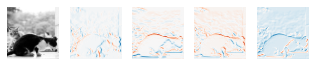

In [1]:
import numpy
import matplotlib.pyplot as plt

# 读取图像，取三个颜色通道中的一个
img = plt.imread('data/test128.jpg')
img = img[:,:,0]

# 准备卷积核
kernels = [
    numpy.array([[-1,0,1],[-1,0,1],[-1,0,1]]),
    numpy.array([[-1,-1,-1],[0,0,0],[1,1,1]]),
    numpy.array([[1,-2,-2],[1,1,-2],[1,1,1]]),
    numpy.array([[1,1,1],[1,1,-2],[1,-2,-2]])]

fig = plt.figure(figsize=(5.4,1))

# 绘制原图像和卷积结果
for i in range(5):
    plt.subplot(1, 5, i+1)
    # 绘制原图像
    if i == 0:
        plt.imshow(img, cmap=plt.cm.gray)
        plt.axis('off')
        continue
    # 计算卷积，对于n*n的卷积核，卷积结果比原图行列各少n-1
    kernel = kernels[i-1]
    conv = numpy.zeros((img.shape[0]-2,img.shape[1]-2))
    for x in range(conv.shape[1]):
        for y in range(conv.shape[0]):
            # 截取原图中对应位置与卷积核大小相同的块
            clip = img[y:y+3,x:x+3]
            # 图像块与卷积核对应元素相乘然后求和
            conv[y,x] = numpy.sum(clip * kernel)
    # 显示卷积结果
    plt.imshow(conv, cmap=plt.cm.RdBu)
    plt.axis('off')


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MnistNet(nn.Module):
    def __init__(self):
        super(MnistNet, self).__init__()
        # 在构造函数中定义组成网络的单元
        # 定义二维卷积层，输入通道1个，输出通道8个，也就是8个卷积核
        # 每个卷积核大小为3，输入各边补齐1行（或列），以便输出尺寸与输入一致
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        # 第二个卷积层输入通道为8个，即上一层的输出
        # 这一层的输出通道为16个，也就是16个卷积核
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        # 定义全连接层
        self.fc1 = nn.Linear(7*7*16, 64)
        self.fc2 = nn.Linear(64, 10)
    def forward(self, x):
        # 每个卷积层使用ReLU激活函数
        # 并使用Max Pooling进行压缩
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # 将卷积层的输出拉平为长度为7*7*16的向量
        # 作为全连接层的输入
        x = x.view(-1, 7*7*16)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# 构造测试输入，第一维是样本编号，第二维是通道编号
# 这个输入包含一个样本，一个通道
x = torch.rand((1, 1, 28, 28))
net = MnistNet()
y = net(x)
# 输出一个1*10的张量
print(y)

tensor([[-0.0028, -0.1338,  0.1795, -0.0525, -0.0171,  0.0581, -0.0580, -0.0060,
         -0.0426, -0.1858]], grad_fn=<AddmmBackward>)


In [5]:
import torch
import torchvision

# 由于数据集是图片，需要将图片转化为张量
# 然后进行归一化，将像素值调整到适合训练的范围
# 下面的数据变换完成这两个操作
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])])

# 下载MNIST数据集
# 将数据集保存在下面的路径
data_path = 'data'
# 数据集包含训练集和测试集两部分数据
train_data = torchvision.datasets.MNIST('data', train=True, transform=data_transform, download=True)
test_data = torchvision.datasets.MNIST('data', train=False, transform=data_transform)

# 从数据集构造加载器
# 加载器每批次提取10个样本
# 乱序加载样本避免顺序相关性
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle=True)

# 实验一下，读取第一批样本
train_input, labels = next(iter(train_loader))
print(train_input.shape)
# 输入的尺寸为10*1*28*28，包含10个样本
print(labels.shape)
# 目标输出的尺寸为10，包含10个标签

torch.Size([10, 1, 28, 28])
torch.Size([10])


In [6]:
# 开始训练之前，选择使用的计算设备
# 默认是CPU，如果检测到了GPU，那么可以使用GPU加速计算
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [7]:
# 准备网络模型
net = MnistNet()
# 将网络模型放在计算设备上，如果使用CPU可以忽略这一步
net = net.to(device)
# 准备交叉熵损失函数
loss_func = torch.nn.CrossEntropyLoss()
# 准备随机梯度下降优化器，设置学习率为0.01
optimizer = torch.optim.SGD(net.parameters(), 0.001)

# %%
# 设置训练循环次数
epochs = 3
for i in range(epochs):
    # 枚举训练集中的数据
    for index, (train_input, labels) in enumerate(train_loader):
        # 将网络置于训练状态
        # 某些层在训练和测试时行为不同，比如批归一化层和Dropout层
        net.train(True)
        # 将数据放在计算设备上
        # 如果使用的是CPU，可以忽略这个步骤
        train_input = train_input.to(device)
        labels = labels.to(device)
        # 计算输出
        output = net(train_input)
        # 计算误差
        loss = loss_func(output, labels)
        # 清空优化器，计算梯度
        optimizer.zero_grad()
        loss.backward()
        # 用梯度优化模型
        optimizer.step()
        # 每训练一段时间观察测试误差
        # 如果观察到测试误差不再继续降低或者训练误差开始低于测试误差
        # 说明开始出现过拟合，应该停止训练
        if index % 1000 == 0:
            # 将网络置于测试状态
            net.train(False)
            test_input, test_labels = next(iter(test_loader))
            test_output = net(test_input)
            test_loss = loss_func(test_output, test_labels)
            # 输出训练误差和测试误差
            print('{0} 训练误差：{1:.4f} 测试误差：{2:.4f}'.format(
                index, loss.item(), test_loss.item()))

0 训练误差：2.2540 测试误差：2.2609
1000 训练误差：2.2746 测试误差：2.2708
2000 训练误差：2.2162 测试误差：2.1887
3000 训练误差：1.9029 测试误差：1.9488
4000 训练误差：1.4062 测试误差：0.8202
5000 训练误差：0.7378 测试误差：0.7470
0 训练误差：1.0060 测试误差：0.6080
1000 训练误差：1.2726 测试误差：0.4931
2000 训练误差：0.1927 测试误差：0.5112
3000 训练误差：0.3592 测试误差：0.2315
4000 训练误差：0.0983 测试误差：0.0739
5000 训练误差：0.8057 测试误差：0.8153
0 训练误差：0.9665 测试误差：0.1562
1000 训练误差：0.0606 测试误差：0.1751
2000 训练误差：0.7754 测试误差：0.0826
3000 训练误差：0.2180 测试误差：0.1164
4000 训练误差：0.2437 测试误差：0.3717
5000 训练误差：0.2441 测试误差：0.2372
